# Homework 5 for Perspective

## Qian Zhang

In [1]:
# import libraries

import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import scipy.optimize as opt
from scipy import integrate as intgr
import numpy.linalg as lin

In [2]:
# income data import
income = np.loadtxt('data/incomes.txt')

### (a)

(45000, 140000)

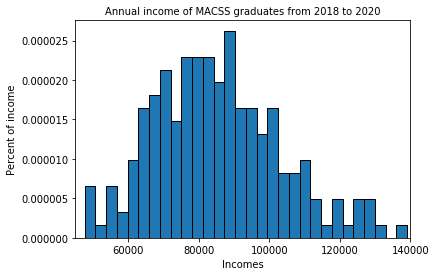

In [3]:
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')
plt.title('Annual income of MACSS graduates from 2018 to 2020', fontsize=10)
plt.xlabel(r'Incomes')
plt.ylabel(r'Percent of income')
plt.xlim([45000,140000])  

### (b)

In [4]:
# define functions

def data_moments(xvals):
    
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

# in order to avoid the long time inter.quad process, directly use the formula in calculation.

def model_moments(mu, sigma):
    
    mean_model = np.exp(mu + sigma ** 2 / 2)
    var_model = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2)
    
    return mean_model, var_model**0.5

def err_vec(xvals, mu, sigma,simple):
    mean_data, std_data = data_moments(xvals)
        
    moms_data = np.array([[mean_data], [std_data]])
    
    mean_model, std_model = model_moments(mu, sigma)
    
    moms_model = np.array([[mean_model], [std_model]])
        
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
        
    return err_vec

def criterion(params, *args):
    
    mu, sigma = params
    xvals,  W = args
    err = err_vec(xvals, mu, abs(sigma), simple=False)
        
    crit_val = err.T @ W @ err
    
    return crit_val

In [5]:
# estimation 

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])

W_hat = np.eye(2)
gmm_args = (income, W_hat)

results = opt.minimize(criterion, params_init, tol=1e-14,args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

# comparison

mean_data, sd_data = data_moments(income)
mean_model, sd_model = model_moments(mu_GMM1, sig_GMM1)

err1 = err_vec(income, mu_GMM1, sig_GMM1,False).reshape(2,)

print('\nMean of points =', mean_data, ', SD of points =', sd_data)
print('Mean of model =', mean_model, ', SD of model =', sd_model)
print('\nGMM criterion function value =', results.fun[0][0])
print('\nError vector=', err1)
results

mu_GMM1= 11.331880866982898  sig_GMM1= 0.20869665246828492

Mean of points = 85276.82360625811 , SD of points = 17992.542128046523
Mean of model = 85276.82542230906 , SD of model = 17992.541705444266

GMM criterion function value = 1.005186460950373e-15

Error vector= [ 2.12959497e-08 -2.34876347e-08]


      fun: array([[1.00518646e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.56166349e-08, 3.01504116e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 12
   status: 0
  success: True
        x: array([11.33188087,  0.20869665])

Text(0, 0.5, 'Percent of income')

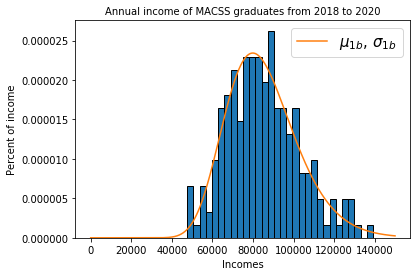

In [6]:
# plot

ax=plt.gca()
point=np.linspace(1e-10, 150000, 50000)
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')


pdf_log_gmm=lognorm.pdf(point, s=sig_GMM1, scale=np.exp(mu_GMM1))
ax.plot(point,pdf_log_gmm,label='$\mu_{1b}$, $\sigma_{1b}$')

ax.legend(fontsize=15) 

plt.title('Annual income of MACSS graduates from 2018 to 2020', fontsize=10)
plt.xlabel(r'Incomes')
plt.ylabel(r'Percent of income')

### (c)

In [7]:
# get the weighted matrix

def get_Err_mat2(pts, mu, sigma, simple=False):
    
    # r个moments，n个obs
    
    R = 2
    N = len(pts)
    
    Err_mat = np.zeros((R, N))
    
    # 倒入data 和 model mom
    
    mean_data, sd_data=data_moments(pts)
    
    mean_model, sd_model = model_moments(mu, sigma)
    
    if simple:    
        Err_mat[0, :] =  mean_model - pts
        Err_mat[1, :] =  sd_model - np.sqrt((mean_data - pts) ** 2)
    else:
        Err_mat[0, :] = (mean_model - pts) / pts
        Err_mat[1, :] = (sd_model-np.sqrt(((mean_data - pts) ** 2))) / np.sqrt(((mean_data - pts) ** 2))
    
    return Err_mat

Err_mat = get_Err_mat2(income, mu_GMM1, sig_GMM1, False)

VCV2 = (1 / income.shape[0]) * (Err_mat @ Err_mat.T)
print('The vairance-covar matrix is: \n\n', VCV2)

W_hat2 = lin.inv(VCV2)
print('\nThe two-step weighted matrix is: \n\n', W_hat2)


The vairance-covar matrix is: 

 [[5.30804094e-02 6.35000837e-03]
 [6.35000837e-03 1.32826953e+04]]

The two-step weighted matrix is: 

 [[ 1.88393433e+01 -9.00645430e-06]
 [-9.00645430e-06  7.52859293e-05]]


In [8]:
# estimation

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
gmm_args_2 = (income , W_hat2)
results_2 = opt.minimize(criterion, params_init, tol=1e-14,args=(gmm_args_2), ## tol和bound的意思？？
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results_2.x
print('mu_GMM 2 steps=', mu_GMM2, ' sig_GMM 2 steps=', sig_GMM2)

# comparison

mean_data, sd_data = data_moments(income)
mean_model, sd_model = model_moments(mu_GMM2, sig_GMM2)
err2 = err_vec(income, mu_GMM2, sig_GMM2,False).reshape(2,)
print('\nMean of points =', mean_data, ', SD of points =', sd_data)
print('Mean of model of two-steps =', mean_model, ', SD of model of twp-steps =', sd_model)
print('\nGMM criterion function value of two-steps =', results_2.fun[0][0])
print('\nError vector of two-steps =', err2)
results_2

mu_GMM 2 steps= 11.331879044981989  sig_GMM 2 steps= 0.20870526332596548

Mean of points = 85276.82360625811 , SD of points = 17992.542128046523
Mean of model of two-steps = 85276.8232983479 , SD of model of twp-steps = 17993.29991766107

GMM criterion function value of two-steps = 1.3379286821657705e-13

Error vector of two-steps = [-3.61071396e-09  4.21168732e-05]


      fun: array([[1.33792868e-13]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.79303681e-08, 1.20507051e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 189
      nit: 37
   status: 0
  success: True
        x: array([11.33187904,  0.20870526])

From the comparison of two methods, the two-step model behaves better on mean estimation, but worse on variance estimation.

Text(0, 0.5, 'Percent of income')

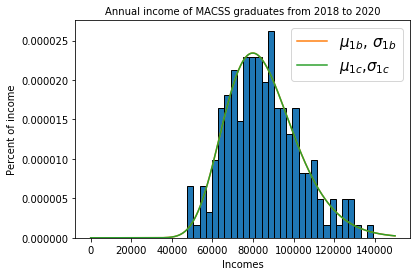

In [9]:
# plot

ax=plt.gca()
point=np.linspace(1e-10, 150000, 50000)
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

pdf_log_gmm=lognorm.pdf(point, s=sig_GMM1, scale=np.exp(mu_GMM1))
pdf_log_gmm2=lognorm.pdf(point, s=sig_GMM2, scale=np.exp(mu_GMM2))
ax.plot(point,pdf_log_gmm,label='$\mu_{1b}$, $\sigma_{1b}$')
ax.plot(point,pdf_log_gmm2,label='$\mu_{1c}$,$\sigma_{1c}$')
ax.legend(fontsize=15)
plt.title('Annual income of MACSS graduates from 2018 to 2020', fontsize=10)
plt.xlabel(r'Incomes')
plt.ylabel(r'Percent of income')

### (d)

In [10]:
# define three moments functions

def data_moments_new(xvals):
    
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = xvals[(xvals >=75000) & (xvals < 100000)].shape[0] / xvals.shape[0]
    bpct_3_dat = xvals[xvals >=100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments_new(mu, sigma):
        
    xfxc = lambda x: lognorm.cdf(x,s=sigma,scale=np.exp(mu))
    bpct_1_mod = xfxc(75000)
    bpct_2_mod = xfxc(100000)-xfxc(75000)
    bpct_3_mod = 1-xfxc(100000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec_new(xvals, mu, sigma, simple):
 
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments_new(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments_new(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
        
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion_new(params, *args):
        
    mu, sigma = params
    xvals, W = args
    
    # the percent difference may face the "divided by zero" problem, so use simple difference here.
    
    err = err_vec_new(xvals, mu, sigma, simple=True)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [11]:
# estimation

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])

# identity matrix

W_hat3 = np.eye(3)

gmm_args_3 = (income, W_hat3)
results_3 = opt.minimize(criterion_new, params_init, tol=1e-14, args=(gmm_args_3),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM3, sig_GMM3 = results_3.x
print('mu_GMM3=', mu_GMM3, ' sig_GMM3=', sig_GMM3)

# comparison

per_data_1, per_data_2, per_data_3 = data_moments_new(income)
per_mod_1, per_mod_2, per_mod_3 = model_moments_new(mu_GMM3, sig_GMM3)

err3 = err_vec_new(income, mu_GMM3, sig_GMM3, True).reshape(3,)

print('\nThe percentage of income<75000 from data =', per_data_1, ', \nThe percentage of 75000<income<=100000 from data =', per_data_2, ', \nThe percentage of 100000<income from data =', per_data_3)
print('\n\nThe percentage of income<75000 from model =', per_mod_1, ', \nThe percentage of 75000<income<=100000 from model =', per_mod_2, ', \nThe percentage of 100000<income from model =', per_mod_3)

print('\nGMM criterion function value for three moments =', results_3.fun[0][0]) 
print('\nError vector for three moments =', err3)
results_3

mu_GMM3= 11.33568132443811  sig_GMM3= 0.21059845136155694

The percentage of income<75000 from data = 0.3 , 
The percentage of 75000<income<=100000 from data = 0.5 , 
The percentage of 100000<income from data = 0.2


The percentage of income<75000 from model = 0.3000000065211137 , 
The percentage of 75000<income<=100000 from model = 0.5000000095756981 , 
The percentage of 100000<income from model = 0.19999998390318818

GMM criterion function value for three moments = 3.93326269520008e-16

Error vector for three moments = [ 6.52111370e-09  9.57569812e-09 -1.60968118e-08]


      fun: array([[3.9332627e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.22065483e-08, -3.33574503e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 11
   status: 0
  success: True
        x: array([11.33568132,  0.21059845])

Text(0, 0.5, 'Percent of income')

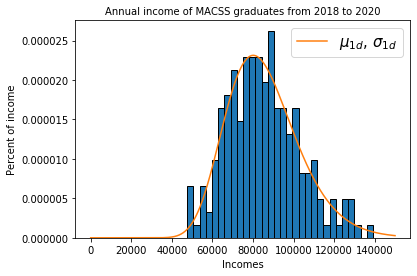

In [12]:
# plot

ax=plt.gca()
point=np.linspace(1e-10, 150000, 50000)
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

pdf_log_gmm3=lognorm.pdf(point, s=sig_GMM3, scale=np.exp(mu_GMM3))
ax.plot(point,pdf_log_gmm3,label='$\mu_{1d}$, $\sigma_{1d}$')

ax.legend(fontsize=15)
plt.title('Annual income of MACSS graduates from 2018 to 2020', fontsize=10)
plt.xlabel(r'Incomes')
plt.ylabel(r'Percent of income')

From the error vector, we can see that the error is quite small, and the estimate is quite accurate. 

### (e)

In [13]:
# get the weighted matrix for three moments

def get_Err_mat3(pts, mu, sigma, simple=False):

    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = model_moments_new(mu, sigma)
        
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] =  pct_1_mod- pts_in_grp1
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pct_2_mod- pts_in_grp2
        pts_in_grp3 = (pts >= 100000)
        Err_mat[2, :] = pct_3_mod- pts_in_grp3
        
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pct_1_mod- pts_in_grp1) / pts_in_grp1 
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pct_2_mod- pts_in_grp2) / pts_in_grp2
        pts_in_grp3 = (pts >= 100000)
        Err_mat[2, :] = (pct_3_mod- pts_in_grp3) / pts_in_grp3
     
    return Err_mat

In [14]:
# Because pts_in grp1/2/3 are all True/False values, so we cannot use percent difference, otherwise we will get 'divided by zero' warning.

Err_mat3 = get_Err_mat3(income, mu_GMM3, sig_GMM3, True)

VCV3 = (1 / income.shape[0]) * (Err_mat3 @ Err_mat3.T)

print('The vairance-covar matrix is: \n\n', VCV3)

W_hat3 = lin.pinv(VCV3)
print('\nThe two-step weighted matrix is: \n\n', W_hat3)

The vairance-covar matrix is: 

 [[ 0.21 -0.15 -0.06]
 [-0.15  0.25 -0.1 ]
 [-0.06 -0.1   0.16]]

The two-step weighted matrix is: 

 [[ 2.25925926 -0.62962963 -1.62962963]
 [-0.62962963  1.81481481 -1.18518519]
 [-1.62962963 -1.18518519  2.81481481]]


In [15]:
# estimation

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
gmm_args_4 = (income , W_hat3)

results_4 = opt.minimize(criterion_new, params_init, tol=1e-14,args=(gmm_args_4),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM4, sig_GMM4 = results_4.x
print('mu_GMM4=', mu_GMM4, ' sig_GMM4=', sig_GMM4)

mu_GMM4= 11.335681326874864  sig_GMM4= 0.21059845272390096


In [16]:
# comparison

per_data_1, per_data_2, per_data_3 = data_moments_new(income)
per_mod_1, per_mod_2, per_mod_3 = model_moments_new(mu_GMM4, sig_GMM4)

err4 = err_vec_new(income, mu_GMM4, sig_GMM4, True).reshape(3,)
print('\nThe percentage of income<75000 from data =', per_data_1, ', \nThe percentage of 75000<income<=100000 from data =', per_data_2, ', \nThe percentage of 100000<income from data =', per_data_3)
print('\n\nThe percentage of income<75000 from model =', per_mod_1, ', \nThe percentage of 75000<income<=100000 from model =', per_mod_2, ', \nThe percentage of 100000<income from model =', per_mod_3)

print('\nGMM criterion function value for three moments =', results_4.fun[0][0])
print('\nError vector for three moments =', err4)
results_4


The percentage of income<75000 from data = 0.3 , 
The percentage of 75000<income<=100000 from data = 0.5 , 
The percentage of 100000<income from data = 0.2


The percentage of income<75000 from model = 0.3000000036775732 , 
The percentage of 75000<income<=100000 from model = 0.5000000076556869 , 
The percentage of 100000<income from model = 0.19999998866673996

GMM criterion function value for three moments = 8.045148150060877e-16

Error vector for three moments = [ 3.67757319e-09  7.65568686e-09 -1.13332601e-08]


      fun: array([[8.04514815e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.56890687e-12, -7.96933154e-13])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 10
   status: 0
  success: True
        x: array([11.33568133,  0.21059845])

Text(0, 0.5, 'Percent of income')

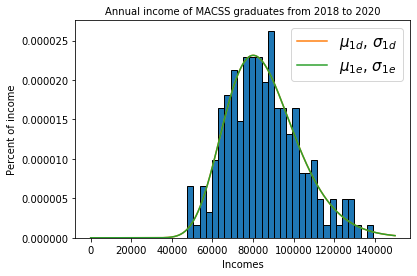

In [17]:
# plot

ax=plt.gca()
point=np.linspace(1e-10, 150000, 50000)
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

pdf_log_gmm4=lognorm.pdf(point, s=sig_GMM4, scale=np.exp(mu_GMM4))
ax.plot(point,pdf_log_gmm3,label='$\mu_{1d}$, $\sigma_{1d}$')
ax.plot(point,pdf_log_gmm4,label='$\mu_{1e}$, $\sigma_{1e}$')
ax.legend(fontsize=15)
plt.title('Annual income of MACSS graduates from 2018 to 2020', fontsize=10)
plt.xlabel(r'Incomes')
plt.ylabel(r'Percent of income')

### (f)

In [18]:
print('The GMM criterion function value for model 1 is: ',results.fun[0][0])
print('The GMM criterion function value for model 2 is: ',results_2.fun[0][0]) # mu sigma
print('The GMM criterion function value for model 3 is: ',results_3.fun[0][0])
print('The GMM criterion function value for model 4 is: ',results_4.fun[0][0])

The GMM criterion function value for model 1 is:  1.005186460950373e-15
The GMM criterion function value for model 2 is:  1.3379286821657705e-13
The GMM criterion function value for model 3 is:  3.93326269520008e-16
The GMM criterion function value for model 4 is:  8.045148150060877e-16


From the comparison of the GMM criterion function value, the model 3 has the smallest value. Therefore, we can argue that the third model best fits the data. 

## Question 2

### (a)

In [19]:
# import the sick.txt

df=pd.read_csv('data/sick.txt')
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [20]:
# define the functions

def err_vec_sick(df,b0,b1,b2,b3):
    
    moms_model=b0+b1*df['age']+b2*df['children']+b3*df['avgtemp_winter']
    
    moms_data=df['sick']
    
    err_vec = moms_model - moms_data
        
    return err_vec

def criterion_sick(params, *args):
        
    b0,b1,b2,b3 = params
    df, W = args
    err = err_vec_sick(df,b0,b1,b2,b3)
    crit_val = err.T @ W @ err
    
    return crit_val

In [21]:
# estimate 

init_guess_new=np.array([0.25,.01,0.4,-.01])
W_sick=np.eye(200)
gmm_arg_sick=(df,W_sick)

results_sick=opt.minimize(criterion_sick, init_guess_new, tol=1e-14, args=gmm_arg_sick, method='L-BFGS-B')

results_sick

      fun: 0.0018212897399187567
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.35773988e-05,  1.96734296e-04,  4.39075859e-06, -1.88117794e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 130
      nit: 8
   status: 0
  success: True
        x: array([ 0.25164429,  0.01293351,  0.40050075, -0.00999172])

In [22]:
# report the estimation

b0_gmm,b1_gmm,b2_gmm,b3_gmm=results_sick.x

print ('GMM estimates for beta_0 is {}.'.format(b0_gmm))
print ('GMM estimates for beta_1 is {}.'.format(b1_gmm))
print ('GMM estimates for beta_2 is {}.'.format(b2_gmm))
print ('GMM estimates for beta_3 is {}.'.format(b3_gmm))

print ('\nGMM criterion function value is {}.'.format(results_sick.fun))

GMM estimates for beta_0 is 0.25164429043982406.
GMM estimates for beta_1 is 0.012933508117164325.
GMM estimates for beta_2 is 0.4005007487189727.
GMM estimates for beta_3 is -0.009991722820415508.

GMM criterion function value is 0.0018212897399187567.
